This presentation is meant to illustrate the functionalities provided by the ROMC inference method using Gaussian Processes.

In [1]:
import timeit
import matplotlib.pyplot as plt
import numpy as np
import scipy.integrate as integrate
import scipy.stats as ss
import elfi

np.random.seed(21)

In [2]:
class Prior:
    def rvs(self, size=None, random_state=None):
        # size from (BS,) -> (BS,1)
        if size is not None:
            size = np.concatenate((size, [1]))
        return ss.uniform(loc=-2.5, scale=5).rvs(size=size, random_state=random_state)

    def pdf(self, theta):
        return ss.uniform(loc=-2.5, scale=5).pdf(theta)

    def logpdf(self, theta):
        return ss.uniform(loc=-2.5, scale=5).logpdf(theta)

In [3]:
class Likelihood:
    r"""Implements the distribution
    P(x|theta) = N(x; theta^4, 1)         if theta in [-0.5, 0.5]
                 N(x; theta + 0.5 + 0.5^4 if theta > 0.5
                 N(x; theta - 0.5 + 0.5^4 if theta < 0.5
    """

    def rvs(self, theta, seed=None):
        """Vectorized sampling from likelihood.

        """
        assert isinstance(theta, np.ndarray)
        theta = theta.astype(np.float)
        samples = np.empty_like(theta)

        c = 0.5 - 0.5 ** 4

        tmp_theta = theta[theta <= -0.5]
        samples[theta <= -0.5] = ss.norm(loc=-tmp_theta - c, scale=1).rvs(random_state=seed)
        theta[theta <= -0.5] = np.inf

        tmp_theta = theta[theta <= 0.5]
        samples[theta <= 0.5] = ss.norm(loc=tmp_theta**4, scale=1).rvs(random_state=seed)
        theta[theta <= 0.5] = np.inf

        tmp_theta = theta[theta < np.inf]
        samples[theta < np.inf] = ss.norm(loc=tmp_theta - c, scale=1).rvs(random_state=seed)
        theta[theta < np.inf] = np.inf

        assert np.allclose(theta, np.inf)
        return samples

    def pdf(self, x, theta):
        """Vectorised pdf evaluation.
        """
        assert isinstance(x, np.ndarray)
        assert isinstance(theta, np.ndarray)
        assert theta.ndim == 1
        assert x.ndim == 1

        BS = theta.shape[0]
        N = x.shape[0]
        theta = theta.astype(np.float)

        pdf_eval = np.zeros((BS))
        c = 0.5 - 0.5 ** 4

        def help_func(lim, mode):
            tmp_theta = theta[theta <= lim]
            tmp_theta = np.expand_dims(tmp_theta, -1)
            scale = np.ones_like(tmp_theta)
            if mode == 1:
                pdf_eval[theta <= lim] = np.prod(ss.norm(loc=-tmp_theta - c, scale=scale).pdf(x), 1)
            elif mode == 2:
                pdf_eval[theta <= lim] = np.prod(ss.norm(loc=tmp_theta**4, scale=scale).pdf(x), 1)
            elif mode == 3:
                pdf_eval[theta <= lim] = np.prod(ss.norm(loc=tmp_theta - c, scale=scale).pdf(x), 1)
            theta[theta <= lim] = np.inf

        big_M = 10**7
        help_func(lim=-0.5, mode=1)
        help_func(lim=0.5, mode=2)
        help_func(lim=big_M, mode=3)
        assert np.allclose(theta, np.inf)
        return pdf_eval

In [4]:
def summary(x):
    assert isinstance(x, np.ndarray)
    if x.ndim == 1:
        return x
    elif x.ndim == 2:
        return np.prod(x, 1)


def create_factor(x):
    """Creates the function g(theta) = L(theta)*prior(theta).

    """
    lik = Likelihood()
    pr = Prior()
    def tmp_func(theta):
        return float(lik.pdf(x, np.array([theta])) * pr.pdf(theta))
    return tmp_func


def approximate_Z(func, a, b):
    """Approximates the partition function with exhaustive integration.
    """
    return integrate.quad(func, a, b)[0]


def create_gt_posterior(likelihood, prior, data, Z):
    """Returns a function that computes the gt posterior
    """
    def tmp_func(theta):
        return likelihood.pdf(data, np.array([theta])) * prior.pdf(np.array([theta])) / Z
    return tmp_func

In [5]:
data = np.array([0.])
dim = data.shape[0]
a = -2.5  # integration left limit
b = 2.5   # integration right limit

likelihood = Likelihood()
prior = Prior()

factor = create_factor(x=data)
Z = approximate_Z(factor, a, b)
gt_posterior_pdf = create_gt_posterior(likelihood, prior, data, Z)

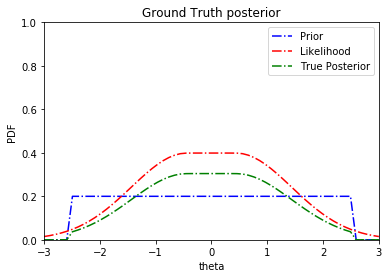

In [6]:
plt.figure()
plt.title("Ground Truth posterior")
plt.xlim(-3, 3)
plt.xlabel("theta")
plt.ylabel("PDF")
plt.ylim(0, 1)

# plot prior
theta = np.linspace(-3, 3, 60)
y = prior.pdf(theta)
plt.plot(theta, y, 'b-.', label='Prior')

# plot likelihood
y = likelihood.pdf(x=data, theta=theta)
plt.plot(theta, y, 'r-.', label='Likelihood')

# plot posterior
y = np.squeeze(np.array([gt_posterior_pdf(th) for th in theta]))
plt.plot(theta, y, 'g-.', label="True Posterior")

plt.legend()
plt.show(block=False)

In [7]:
def simulator(theta, dim, batch_size=10000, random_state=None):
    likelihood = Likelihood()
    theta = np.repeat(theta, dim, -1)
    return likelihood.rvs(theta, seed=random_state)


elfi.new_model("1D_example")
elfi_prior = elfi.Prior(Prior(), name="theta")
elfi_simulator = elfi.Simulator(simulator, elfi_prior, dim, observed=np.expand_dims(data, 0), name="simulator")
dist = elfi.Distance('euclidean', elfi_simulator, name="dist")

In [8]:
bounds = [(-2.5, 2.5)]
dim = data.shape[-1]

# Defines the ROMC inference method
romc = elfi.ROMC(dist, bounds)

In [9]:
# Define n1 optimisation problems, fit one GP for each one and find the optimal point 
n1 = 5
seed = 21
use_gp = True
romc.solve_problems(n1=n1, seed=seed, use_bo=True, optimizer_args={})

### Solving problems using Bayesian optimisation ###
Progress: |██████████████████████████████████████████████████| 100.0% Complete
Time: 14.149 sec
Time: 14.149 sec


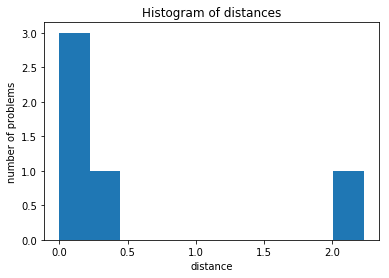

In [10]:
# plots the disribution of optimal distances
romc.distance_hist(bins=10)

In [11]:
eps = .5
romc.estimate_regions(eps=eps, fit_models=False)

Total solutions: 5, Accepted solutions after filtering: 4
### Estimating regions ###

Progress: |██████████████████████████████████████████████████| 100.0% Complete
Time: 0.094 sec 



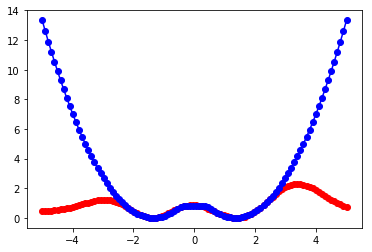

In [12]:
tmp = romc.optim_problems[2]
x = np.linspace(-5, 5, 100)
y1 = [tmp.surrogate_objective(np.atleast_1d(ii)) for ii in x]
y2 = [tmp.objective(np.atleast_1d(ii)) for ii in x]

plt.figure()
plt.plot(x, y1, "r-o")
plt.plot(x, y2, "b-o")
plt.show()

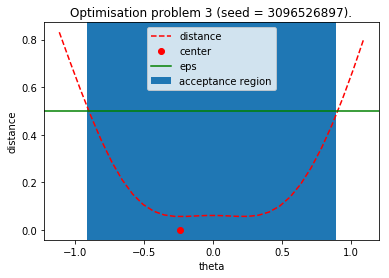

In [13]:
romc.visualize_region(3)

## Inference

In [14]:
theta = np.array([[2.]])
print("Posterior evaluation: f(theta=%.3f)=%.3f" %(theta, romc.eval_posterior(theta=theta)))

Posterior evaluation: f(theta=2.000)=0.333


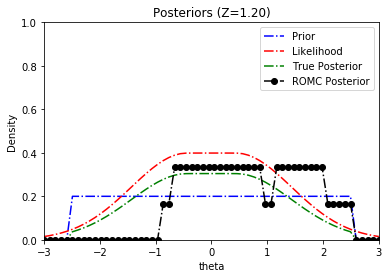

In [15]:
# make plot
plt.figure()
plt.title("Posteriors (Z=%.2f)" % romc.romc_posterior.partition)
plt.xlim(-3, 3)
plt.xlabel("theta")
plt.ylabel("Density")
plt.ylim(0, 1)

# plot prior
theta = np.linspace(-3, 3, 60)
y = prior.pdf(theta)
plt.plot(theta, y, 'b-.', label='Prior')

# plot likelihood
y = likelihood.pdf(x=data, theta=theta)
plt.plot(theta, y, 'r-.', label='Likelihood')

# plot posterior
y = np.squeeze(np.array([gt_posterior_pdf(th) for th in theta]))
plt.plot(theta, y, 'g-.', label="True Posterior")

# plot ROMC posterior
y = [romc.eval_posterior(np.array([[th]])) for th in theta]
tmp = np.squeeze(np.array(y))
plt.plot(theta, tmp, 'k-.o', label="ROMC Posterior")

plt.legend()
plt.show(block=False)

In [16]:
n2 = 20
tmp = romc.sample(n2=n2, seed=seed)

### Getting Samples from the posterior ###

Progress: |██████████████████████████████████████████████████| 100.0% Complete
Time: 0.172 sec 



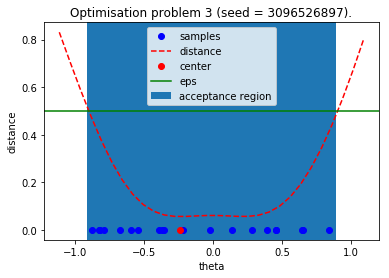

In [17]:
# As before but now it plots the samples as well
romc.visualize_region(3)

In [18]:
# compute expectation
print("Expected value   : %.3f" % romc.compute_expectation(h = lambda x: np.squeeze(x)))
print("Expected variance: %.3f" % romc.compute_expectation(h =lambda x: np.squeeze(x)**2))

Expected value   : 0.624
Expected variance: 1.253


## Evaluation

In [19]:
def wrapper(x):
    res = []
    for i in range(x.shape[0]):
        tmp = x[i]
        res.append(gt_posterior_pdf(float(tmp)))
    return np.array(res)

print(romc.compute_divergence(wrapper, distance="Jensen-Shannon"))

0.3255577957775223


In [20]:
# compute ESS
print("Nof Samples: %d, ESS: %.3f" % (len(romc.result.weights), romc.compute_ess()))

Nof Samples: 80, ESS: 78.048


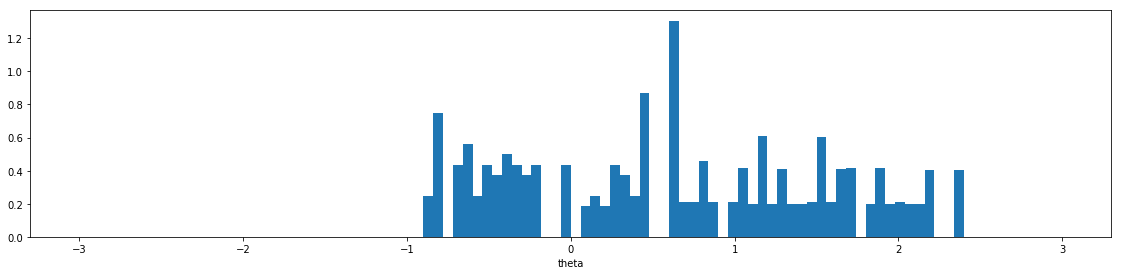

In [21]:
romc.result.plot_marginals(weights=romc.result.weights, bins=100, density=True, range=(-3,3))
plt.show()